In [5]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
import os
import warnings
import random
from PIL import Image
import shutil
warnings.filterwarnings('ignore')

In [6]:
## Ensure Reproducibility
# Set random seeds
random.seed(42)
np.random.seed(42)
tf.random.set_seed(42)

# Force deterministic operations 
os.environ['PYTHONHASHSEED'] = '0'
os.environ['TF_DETERMINISTIC_OPS'] = '1'
os.environ['TF_CUDNN_DETERMINISTIC'] = '1'
tf.config.experimental.enable_op_determinism()

In [ ]:
## Data setup
DATA_DIR = r"[FOLDER PATH]" # Folder path here
BATCH_SIZE = 8
IMG_HEIGHT = 350 # Target height take (350)
IMG_WIDTH = 512 # Width is fixed (512)

# Data generators with augmentation
train_datagen = ImageDataGenerator(rotation_range=15, brightness_range=[0.8, 1.2], horizontal_flip=True, shear_range=0.1, zoom_range=0.1, validation_split=0.2)
val_datagen = ImageDataGenerator(validation_split=0.2)

# Load data
train_generator = train_datagen.flow_from_directory(
    DATA_DIR,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    color_mode='grayscale',
    class_mode='binary',
    subset='training',
    shuffle=True,
    seed=42
)
validation_generator = val_datagen.flow_from_directory(
    DATA_DIR,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    color_mode='grayscale',
    class_mode='binary',
    subset='validation',
    shuffle=False,
    seed=42
)

print(f"Training samples: {train_generator.samples}")
print(f"Validation samples: {validation_generator.samples}")
print(f"Class indices: {train_generator.class_indices}")

Found 112 images belonging to 2 classes.
Found 27 images belonging to 2 classes.
Training samples: 112
Validation samples: 27
Class indices: {'nil': 0, 'water': 1}


In [8]:
## Build ResNet50 Transfer Learning Model
def create_resnet_model():
    # Reset random state
    tf.random.set_seed(42)
    
    # Input for grayscale images
    inputs = layers.Input(shape=(IMG_HEIGHT, IMG_WIDTH, 1))
    
    # Convert grayscale to RGB for ResNet50
    x = layers.Lambda(lambda x: tf.concat([x, x, x], axis=-1))(inputs)
    
    # ResNet50 backbone
    base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(IMG_HEIGHT, IMG_WIDTH, 3), pooling=None)
    
    # Unfreeze top layers
    base_model.trainable = True
    for layer in base_model.layers[:-20]:
        layer.trainable = False
    
    # Base Model and custom classifier
    x = base_model(x)
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dropout(0.5)(x)
    x = layers.Dense(256, activation='relu')(x)
    x = layers.Dropout(0.3)(x)
    x = layers.Dense(64, activation='relu')(x)
    x = layers.Dropout(0.2)(x)
    outputs = layers.Dense(1, activation='sigmoid')(x)
    model = keras.Model(inputs, outputs)
    return model

# Create and compile model
model = create_resnet_model()
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.0001),
    loss='binary_crossentropy',
    metrics=['accuracy', 'precision', 'recall']
)

print(f"Trainable parameters: {model.count_params():,}")


Trainable parameters: 24,128,769


In [9]:
## Training callbacks
callbacks = [
    EarlyStopping(monitor='val_accuracy', patience=6, restore_best_weights=True, verbose=1),
    ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=3, min_lr=1e-7, verbose=1)
]

# Train model
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // BATCH_SIZE,
    epochs=15,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // BATCH_SIZE,
    callbacks=callbacks,
    verbose=1
)

Epoch 1/15
14/14 ━━━━━━━━━━━━━━━━━━━━ 19s 978ms/step - accuracy: 0.4623 - loss: 1.0063 - precision: 0.6403 - recall: 0.4691 - val_accuracy: 0.6250 - val_loss: 0.6760 - val_precision: 1.0000 - val_recall: 0.3077 - learning_rate: 1.0000e-04
Epoch 2/15
14/14 ━━━━━━━━━━━━━━━━━━━━ 13s 945ms/step - accuracy: 0.6222 - loss: 0.6693 - precision: 0.6756 - recall: 0.7654 - val_accuracy: 0.6667 - val_loss: 0.5975 - val_precision: 0.6316 - val_recall: 0.9231 - learning_rate: 1.0000e-04
Epoch 3/15
14/14 ━━━━━━━━━━━━━━━━━━━━ 14s 1s/step - accuracy: 0.6847 - loss: 0.5968 - precision: 0.6933 - recall: 0.8519 - val_accuracy: 0.6667 - val_loss: 0.5751 - val_precision: 0.6316 - val_recall: 0.9231 - learning_rate: 1.0000e-04
Epoch 4/15
14/14 ━━━━━━━━━━━━━━━━━━━━ 15s 1s/step - accuracy: 0.7026 - loss: 0.5472 - precision: 0.7667 - recall: 0.7440 - val_accuracy: 0.6667 - val_loss: 0.6046 - val_precision: 0.6316 - val_recall: 0.9231 - learning_rate: 1.0000e-04
Epoch 5/15
14/14 ━━━━━━━━━━━━━━━━━━━━ 15s 1s/step 

Evaluating model
4/4 ━━━━━━━━━━━━━━━━━━━━ 4s 843ms/step
              precision    recall  f1-score   support

         Nil       0.83      0.91      0.87        11
       Water       0.93      0.88      0.90        16

    accuracy                           0.89        27
   macro avg       0.88      0.89      0.89        27
weighted avg       0.89      0.89      0.89        27

Accuracy:  0.889
Precision: 0.933
Recall:    0.875
F1 Score:  0.903
ROC AUC:   0.903


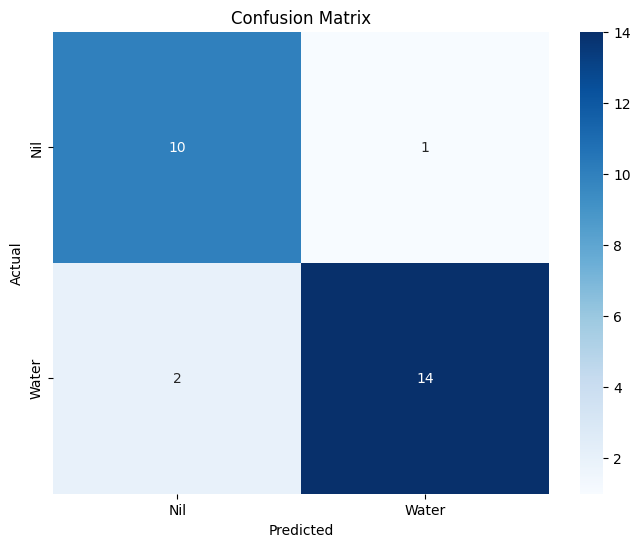

In [10]:
## Evaluate model
def evaluate_model(model, generator):
    generator.reset()
    y_pred_proba = model.predict(generator, verbose=1)
    y_pred = (y_pred_proba > 0.5).astype(int).flatten()
    y_true = generator.classes
    
    # Classification report
    print(classification_report(y_true, y_pred, target_names=['Nil', 'Water']))
    
    # Calculate metrics
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    auc = roc_auc_score(y_true, y_pred_proba)
    
    print(f"Accuracy:  {accuracy:.3f}")
    print(f"Precision: {precision:.3f}")
    print(f"Recall:    {recall:.3f}")
    print(f"F1 Score:  {f1:.3f}")
    print(f"ROC AUC:   {auc:.3f}")
    
    # Confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Nil', 'Water'], yticklabels=['Nil', 'Water'])
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()
    
    return accuracy, precision, recall, f1, auc

print("Evaluating model")
accuracy, precision, recall, f1, auc = evaluate_model(model, validation_generator)

Plotting training history


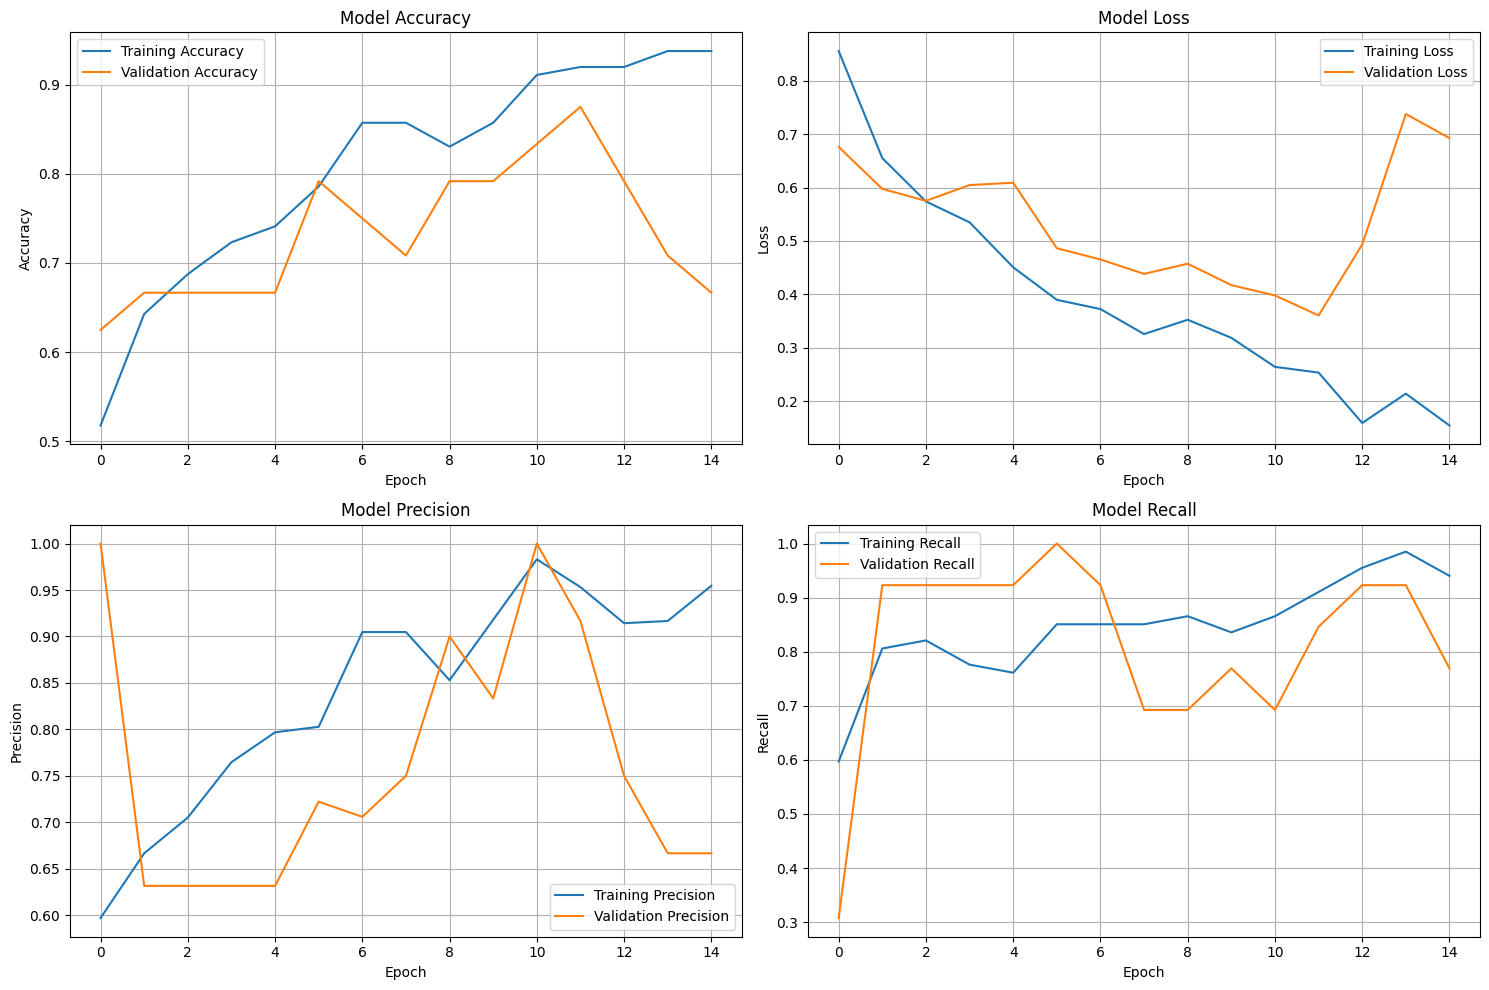

In [11]:
## Training History
def plot_training_history(history):
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    
    # Accuracy
    axes[0, 0].plot(history.history['accuracy'], label='Training Accuracy')
    axes[0, 0].plot(history.history['val_accuracy'], label='Validation Accuracy')
    axes[0, 0].set_title('Model Accuracy')
    axes[0, 0].set_xlabel('Epoch')
    axes[0, 0].set_ylabel('Accuracy')
    axes[0, 0].legend()
    axes[0, 0].grid(True)
    
    # Loss
    axes[0, 1].plot(history.history['loss'], label='Training Loss')
    axes[0, 1].plot(history.history['val_loss'], label='Validation Loss')
    axes[0, 1].set_title('Model Loss')
    axes[0, 1].set_xlabel('Epoch')
    axes[0, 1].set_ylabel('Loss')
    axes[0, 1].legend()
    axes[0, 1].grid(True)
    
    # Precision
    axes[1, 0].plot(history.history['precision'], label='Training Precision')
    axes[1, 0].plot(history.history['val_precision'], label='Validation Precision')
    axes[1, 0].set_title('Model Precision')
    axes[1, 0].set_xlabel('Epoch')
    axes[1, 0].set_ylabel('Precision')
    axes[1, 0].legend()
    axes[1, 0].grid(True)
    
    # Recall
    axes[1, 1].plot(history.history['recall'], label='Training Recall')
    axes[1, 1].plot(history.history['val_recall'], label='Validation Recall')
    axes[1, 1].set_title('Model Recall')
    axes[1, 1].set_xlabel('Epoch')
    axes[1, 1].set_ylabel('Recall')
    axes[1, 1].legend()
    axes[1, 1].grid(True)
    
    plt.tight_layout()
    plt.show()

print("Plotting training history")
plot_training_history(history)

In [12]:
## Confidence scoring
def interpret_prediction(confidence_score):
    if confidence_score > 0.8:
        return f"HIGH CONFIDENCE: {confidence_score:.1%}"
    elif confidence_score > 0.6:
        return f"MEDIUM CONFIDENCE: {confidence_score:.1%}"
    else:
        return f"LOW CONFIDENCE: {confidence_score:.1%} - Manual review recommended"

def test_predictions(model, generator, num_samples=10):
    generator.reset()
    images, labels = next(generator)
    filenames = generator.filenames[:len(images)]
    
    predictions = model.predict(images[:num_samples], verbose=0)
    
    results = []
    for i in range(min(num_samples, len(images))):
        confidence = predictions[i][0]
        predicted_class = 1 if confidence > 0.5 else 0
        true_label = 'Water' if labels[i] == 1 else 'Nil'
        pred_label = 'Water' if predicted_class == 1 else 'Nil'
        confidence_interp = interpret_prediction(confidence)
        
        results.append({
            'Filename': os.path.basename(filenames[i]),
            'True_Label': true_label,
            'Predicted_Label': pred_label,
            'Confidence_Score': confidence,
            'Confidence_Interpretation': confidence_interp,
            'Correct_Prediction': predicted_class == labels[i]
        })
    
    return pd.DataFrame(results)

print("Testing predictions with confidence scores")
predictions_df = test_predictions(model, validation_generator, 10)
print(predictions_df.to_string(index=False))

Testing predictions with confidence scores
     Filename True_Label Predicted_Label  Confidence_Score                         Confidence_Interpretation  Correct_Prediction
nil_E1685.png        Nil             Nil          0.316742 LOW CONFIDENCE: 31.7% - Manual review recommended                True
nil_E1690.png        Nil             Nil          0.336134 LOW CONFIDENCE: 33.6% - Manual review recommended                True
nil_E1691.png        Nil             Nil          0.368439 LOW CONFIDENCE: 36.8% - Manual review recommended                True
nil_E1693.png        Nil             Nil          0.196845 LOW CONFIDENCE: 19.7% - Manual review recommended                True
nil_E1695.png        Nil             Nil          0.221899 LOW CONFIDENCE: 22.2% - Manual review recommended                True
nil_E1697.png        Nil             Nil          0.301160 LOW CONFIDENCE: 30.1% - Manual review recommended                True
nil_E1700.png        Nil             Nil          0.14

Visualizing ResNet50 filters


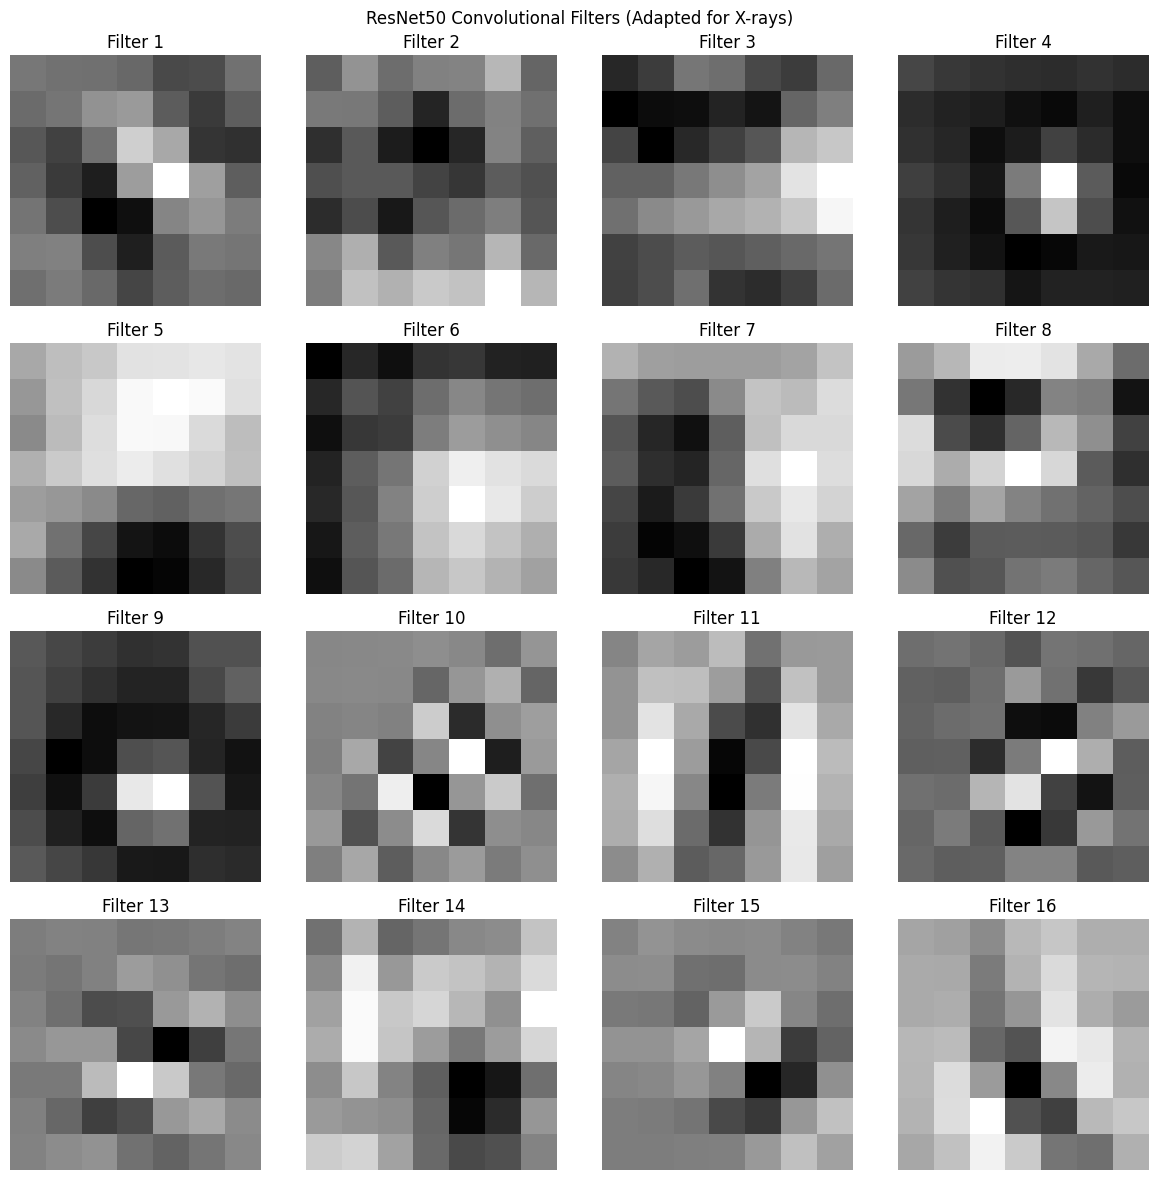

In [13]:
## Visualize ResNet50 filters
def visualize_resnet_filters(model):
    try:
        # Find ResNet50 base model
        resnet_base = None
        for layer in model.layers:
            if hasattr(layer, 'layers') and len(layer.layers) > 10:
                resnet_base = layer
                break
        
        if resnet_base is None:
            print("Could not find ResNet50 base model")
            return
        
        # Get first conv layer
        conv1_layer = None
        for layer in resnet_base.layers:
            if 'conv1' in layer.name and hasattr(layer, 'kernel'):
                conv1_layer = layer
                break
        
        if conv1_layer is None:
            print("Could not find conv1 layer in ResNet50")
            return
        
        # Get filters
        filters = conv1_layer.kernel.numpy()
        
        # Normalize for visualization
        f_min, f_max = filters.min(), filters.max()
        filters_norm = (filters - f_min) / (f_max - f_min)
        
        # Plot first 16 filters
        plt.figure(figsize=(12, 12))
        for i in range(16):
            plt.subplot(4, 4, i+1)
            plt.imshow(filters_norm[:, :, 0, i], cmap='gray')
            plt.title(f'Filter {i+1}')
            plt.axis('off')
        
        plt.suptitle('ResNet50 Convolutional Filters (Adapted for X-rays)')
        plt.tight_layout()
        plt.show()
        
    except Exception as e:
        print(f"Visualization failed: {str(e)}")

print("Visualizing ResNet50 filters")
visualize_resnet_filters(model)

In [ ]:
## Real live Prediction Test
def test_single_image(image_path, model):
    # Temp directory structure
    temp_dir = "temp_single_test"
    os.makedirs(f"{temp_dir}/test", exist_ok=True)
    temp_image_path = f"{temp_dir}/test/{os.path.basename(image_path)}"
    shutil.copy2(image_path, temp_image_path)
    
    # Use same preprocessing as training/validation
    test_datagen = ImageDataGenerator()
    test_generator = test_datagen.flow_from_directory(temp_dir, target_size=(IMG_HEIGHT, IMG_WIDTH), batch_size=1, color_mode='grayscale', class_mode=None, shuffle=False)
    
    # Get prediction using correct pipeline
    prediction = model.predict(test_generator, verbose=0)[0][0]
    predicted_class = 'Water' if prediction > 0.5 else 'Nil'
    confidence_interp = interpret_prediction(prediction)
    
    # Load image for display
    display_img = Image.open(image_path).convert('L')
    display_img = display_img.resize((IMG_WIDTH, IMG_HEIGHT))
    
    # Visualization
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(display_img, cmap='gray')
    plt.title(f'Test: {os.path.basename(image_path)}')
    plt.axis('off')
    
    plt.subplot(1, 2, 2)
    plt.text(0.1, 0.7, f"Prediction: {predicted_class}", fontsize=14, weight='bold')
    plt.text(0.1, 0.5, f"Confidence: {prediction:.3f}", fontsize=12)
    plt.text(0.1, 0.3, confidence_interp, fontsize=10)
    plt.xlim(0, 1)
    plt.ylim(0, 1)
    plt.axis('off')
    plt.title('Results')
    plt.tight_layout()
    plt.show()
    
    # Cleanup
    shutil.rmtree(temp_dir)
    
    print(f"File: {os.path.basename(image_path)}")
    print(f"Prediction: {predicted_class}")
    print(f"Confidence: {prediction:.6f}")
    print(f"Interpretation: {confidence_interp}")
    
    return prediction, predicted_class

# Test image (uncomment below)
# test_single_image(r"[IMAGE PATH]", model) # Image path here

In [15]:
## Save the trained model
model.save('Aircraft Flap Water Ingression CNN Analysis.keras')